In [1]:
import numpy as np 
import scipy.stats as scistats
import scipy.io as sio 
from matplotlib import pyplot as plt 
import scipy.integrate as integrate


# Question 1

# Question 2

This question investigates rejection sampling. 

We do not know $p(\theta)$ and need to calculate $Z$. 

How do I go about selecting the proposal distribution? 

Part 3: compare to Question 1. 

Part 5: see how the number of samples influences the results. 

Discussions in bullet form. 

# Question 3

This question investigates importance sampling. 

# Question 4

Links to look at:
- https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo
- https://arxiv.org/pdf/1909.12313.pdf
- https://link.springer.com/article/10.3758/s13423-016-1015-8


This question focuses on using given samples to perform inference. The following linear hardening model was considered:
\begin{equation}
\sigma (\epsilon_n) = E \cdot \epsilon \cdot \left( 1 - h \left( \epsilon - \frac{\sigma_y}{E} \right) \right) + \left( \sigma_y + \frac{H \cdot E}{H + E} \right) \cdot \left( \epsilon - \frac{\sigma_y}{E} \right) \cdot h \left( \epsilon - \frac{\sigma_y}{E} \right) 
\end{equation}
with the unknown parameters of yield strength $\sigma_y$, plastic modulus $H$, and Young's modulus $E$. 

The measurements of the stress were modelled using:
\begin{equation} \label{eq: measure_model}
s_n = \sigma (\epsilon_n) + v_n
\end{equation}
where $\epsilon_n$ is the strain at measurement $n$; $\sigma (\epsilon)$ is the actual stress for the strain $\epsilon$; $v_n \tilde \mathcal{N} (0, \eta^2)$ and the standard deviation of the noise $\eta$ is 15. $s$ refers to the measurements and $\sigma$ refers to the prediction of the model. 

Markov Chain Monte Carlo (MCMC) was used to obtain the unknown parameters: samples from the posterior distribution over $E$, $\sigma_y$ and $H$. Therefore, the posterior samples were given in the provided dataset. 

MCMC methods are primarily used for calculating numerical approximations of multi-dimensional integrals. 

The acceptance rate of just over 20\% was assumed to be sufficent. 



### Given data

In [2]:
dataDict = sio.loadmat("mcmc_material_linear_hardening_N20.mat")
dataDict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'time_total', 'time_avg', 'acceptance_rate', 'acceptance_count', 'parm_samples', 'stress_m', 'strain_m', 'proposal_scaling', 'stddev_of_noise'])

In [3]:
print(dataDict["stddev_of_noise"])
print(dataDict["acceptance_rate"])
print(dataDict["acceptance_count"])

[[15]]
[[0.2303     0.22574    0.27546333]]
[[1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Standard deviation of the noise: 15.0


Text(0, 0.5, "Young's modulus $E$")

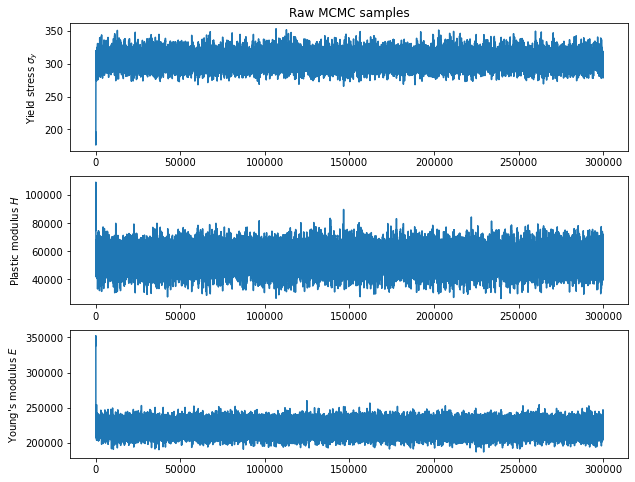

In [4]:

# These are the measurements available in the file: 
strain_m = dataDict["strain_m"].squeeze()
stress_m = dataDict["stress_m"].squeeze()

# These are the posterior samples:
parm_samples = dataDict["parm_samples"].squeeze()

# This is the standard deviation of the noise.
SIGMA = float(dataDict["stddev_of_noise"])
print("Standard deviation of the noise:", SIGMA)

def stress(e,sigma_y,H,E):
    h = lambda x: np.heaviside(x,1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

plt.figure(1,figsize=(10,8))
plt.subplot(311)
plt.title("Raw MCMC samples")
plt.plot(parm_samples[:,0])
plt.ylabel("Yield stress $\sigma_y$")
plt.subplot(312)
plt.plot(parm_samples[:,1])
plt.ylabel("Plastic modulus $H$")
plt.subplot(313)
plt.plot(parm_samples[:,2])
plt.ylabel("Young's modulus $E$")



### Part 1

The given stress and strain measurements are plotted in Figure~\ref{ADD}, along with the stress-strain model using the following parameters: $\sigma_y = 300, H = 49000, E = 210000$.

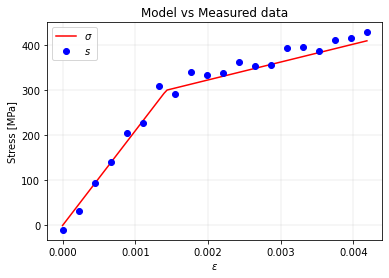

In [5]:

strain_model = np.linspace(0, strain_m[-1], 100)
sigma_y = 300
H = 49000
E = 210000

stress_model = stress(strain_model, sigma_y, H, E)

plt.figure(1)
plt.plot(strain_model, stress_model, 'r', label='$\sigma$')
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$')
plt.ylabel('Stress [MPa]')
plt.title('Model vs Measured data')
plt.grid(linewidth=0.2)
plt.legend()


### Part 2

There are 3 unknown parameters: $E$, $\sigma_y$ and $H$, denoted by $\mathbf{\theta}$.

The likelihood function $p(s_n|\mathbf{\theta})$ measures how well the model, with the candidate parameters $\mathbf{\theta}$, fit the measured data, i.e. it measures the likelihood that the parameters and the model generated the observed data $s_n$.

If the data are independently and identically generated, the likelihood function can be written as:
\begin{equation}
\begin{aligned}
p(\mathbf{s} | \mathbf{\theta}) &= \prod_{n=1}^N \mathcal{N} (s_n | \mathbf{\theta}, 15^2) \\
&= \prod_{n=1}^N p_m (s_n | \mathbf{\theta})
\end{aligned}
\end{equation}

and the log-likelihood can be written as:
\begin{equation}
log \; p(\mathbf{s} | \mathbf{\theta}) = \sum_{n=1}^N log \; p_m (s_n | \mathbf{\theta})
\end{equation}

It must be noted that the likelihood function is not a distribution over $\mathbf{\theta}$.

The log-likelihood of the model given by Equation~\ref{eq: measure_model} was calculated using the given parameter values.

In [6]:
parameters = [300, 49000, 210000]

def log_likelihood(measured_strain, measured_stress, parm): 
    sigma_y, H, E = parm[0], parm[1], parm[2]
    Z = len(measured_strain)
    
    ll = 0
    for n in range(Z):
        mean = stress(measured_strain[n], sigma_y, H, E)
        std = SIGMA
        log_of_height = scistats.norm.logpdf(measured_stress[n], mean, std) # log of PDF
        ll += log_of_height
    
    return ll


In [11]:

log_like = log_likelihood(strain_m, stress_m, parameters)
print("Log-likelihood:", log_like)


Log-likelihood: -85.01133484296402


### Part 3

Samples have been provided. They were drawn from the unnormalised posterior distribution. In the sample generating process, variance is important as it determines the range from which samples are taken. It may be too large, therefore, proposing unsensible samples. This highlights the importance of the parameter tuning process. Smaller variance will increase correlation. 

The following empirical posterior marginal distributions were obtained using all of the given samples:

(Would be nice to compare MCMC with grid-based solution but have not done that and do not think it is expected)

Text(0, 0.5, 'Density')

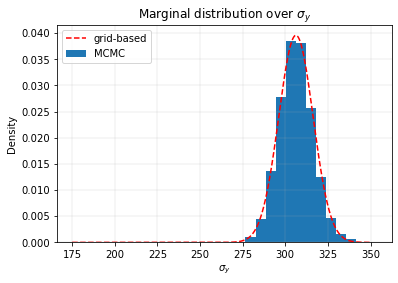

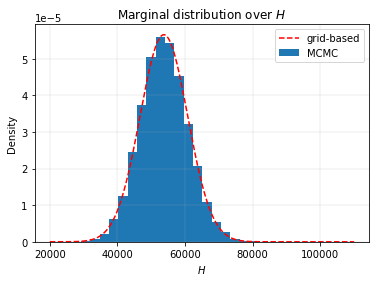

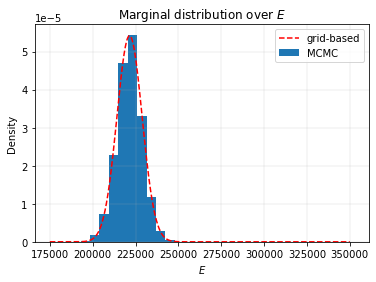

In [89]:

yield_stress_samples = parm_samples[:,0]
H_samples = parm_samples[:,1]
E_samples = parm_samples[:,2]

var_yield = np.var(yield_stress_samples)
var_H = np.var(H_samples)
var_E = np.var(E_samples)

yield_grid = np.linspace(175, 350, 10000)
yield_distrib = scistats.norm.pdf(yield_grid, loc=np.mean(yield_stress_samples), scale=np.sqrt(var_yield))

H_grid = np.linspace(20000, 110000, 10000)
H_distrib = scistats.norm.pdf(H_grid, loc=np.mean(H_samples), scale=np.sqrt(var_H))

E_grid = np.linspace(175000, 350000, 10000)
E_distrib = scistats.norm.pdf(E_grid, loc=np.mean(E_samples), scale=np.sqrt(var_E))


# YIELD STRESS
plt.figure(1)
plt.grid(linewidth=0.2)
plt.plot(yield_grid, yield_distrib, 'r--', label="grid-based")
plt.hist(yield_stress_samples,density=True,bins=30, label='MCMC')
plt.title(r"Marginal distribution over $\sigma_y$")
plt.legend()
plt.xlabel(r"$\sigma_y$")
plt.ylabel("Density")

# PLASTIC MODULUS
plt.figure(2)
plt.grid(linewidth=0.2)
plt.plot(H_grid, H_distrib, 'r--', label="grid-based")
plt.hist(H_samples,density=True,bins=30, label='MCMC')
plt.title(r"Marginal distribution over $H$")
plt.legend()
plt.xlabel(r"$H$")
plt.ylabel("Density")

# ELASTIC MODULUS
plt.figure(3)
plt.grid(linewidth=0.2)
plt.plot(E_grid, E_distrib, 'r--', label="grid-based")
plt.hist(E_samples,density=True,bins=30, label='MCMC')
plt.title(r"Marginal distribution over $E$")
plt.legend()
plt.xlabel(r"$E$")
plt.ylabel("Density")



Additionally, the correlation between each signal and itself was calculated. The shifts ('noise') around zero refer to estimation errors. The figures below show that the samples for each are mostly correlated with themselves and there is not much structure in the correlation.

MAKE SURE ABOUT THIS: (The example in the demo looks similar to this but he says it is highly correlated?) (Would be good if can plot the grid-based solution as he uses this to compare and to support correlation)

Therefore, it was found that the samples were uncorrelated. This is shown by the original sample plots that indicate the samples were likely independently sampled and they are shown to rapidly converge to the domain of the actual solution. This is also highlighted by the sensible marginal distribution histograms that seem to represent the expected Gaussian distributions.  



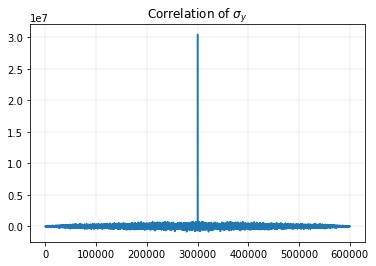

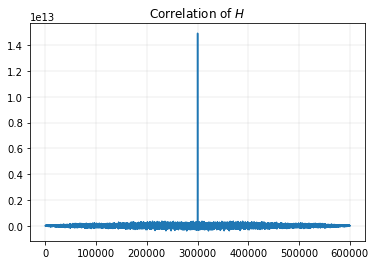

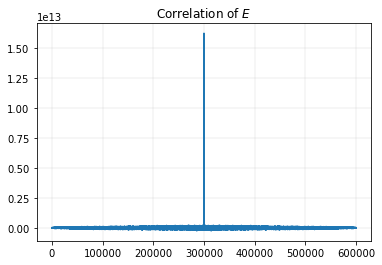

In [13]:

import scipy.signal as scisig

corr_sigma_y = scisig.correlate(yield_stress_samples-np.mean(yield_stress_samples),yield_stress_samples-np.mean(yield_stress_samples))
corr_H = scisig.correlate(H_samples-np.mean(H_samples),H_samples-np.mean(H_samples))
corr_E = scisig.correlate(E_samples-np.mean(E_samples),E_samples-np.mean(E_samples))

plt.figure(1)
plt.plot(corr_sigma_y)
plt.title(r"Correlation of $\sigma_y$")
plt.grid(linewidth=0.2)

plt.figure(2)
plt.plot(corr_H)
plt.title(r"Correlation of $H$")
plt.grid(linewidth=0.2)

plt.figure(3)
plt.plot(corr_E)
plt.title(r"Correlation of $E$")
plt.grid(linewidth=0.2)




It was decided to investigate using a subset of the samples (ignoring the burn-in period), as well as thinning. Thinning of samples is used to remove correlation.

Case 1:
- Subset of samples from 150000 to 300000 (50\%).
- Thinning of this subset, taking every 10th sample.

Implementing Case 1 showed to have a negligible affect on the marginal distributions. A small improvement is made in the distributions' relation to a Gaussian. This supports that the samples were not highly correlated.   

Taking larger steps in the case of thinning the sample subset of Case 1 generally provided inaccurate distributions with larger variations and less relation to a Gaussian. 

Furthermore, decreasing the size of the sample subset only resulted in distribution deviations when the subset was approximately smaller than 30000 (10\% of total).   


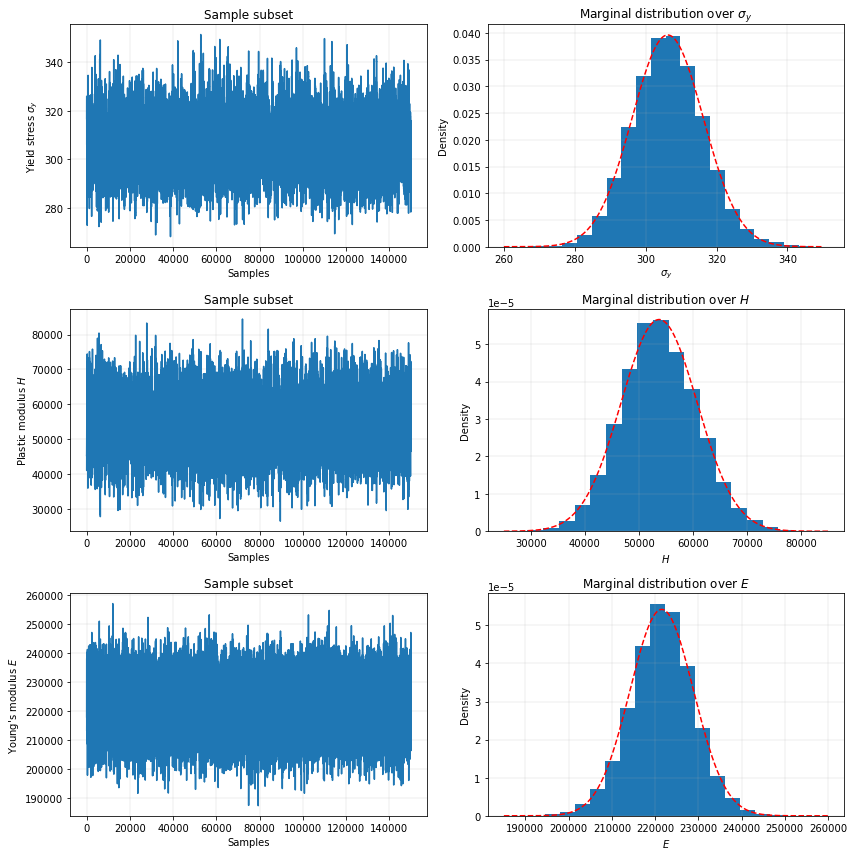

In [90]:
# Again, it would be good to superimpose the grid-based solutions. 

index = np.arange(150000,300000) # Using a subset of the samples  
# index = np.arange(150000,300000)[::10] # With thinning

# print(len(index))

yield_grid = np.linspace(260, 350, 10000)
yield_distrib = scistats.norm.pdf(yield_grid, loc=np.mean(yield_stress_samples), scale=np.sqrt(var_yield))
H_grid = np.linspace(25000, 85000, 10000)
H_distrib = scistats.norm.pdf(H_grid, loc=np.mean(H_samples), scale=np.sqrt(var_H))
E_grid = np.linspace(185000, 260000, 10000)
E_distrib = scistats.norm.pdf(E_grid, loc=np.mean(E_samples), scale=np.sqrt(var_E))



fig1, axs1 = plt.subplots(3, 2, figsize=(12,12))
axs1[0][0].plot(yield_stress_samples[index])
axs1[0][0].set_xlabel('Samples')
axs1[0][0].set_ylabel("Yield stress $\sigma_y$")
axs1[0][0].set_title('Sample subset')
axs1[0][0].grid(linewidth=0.2)
axs1[0][1].hist(yield_stress_samples[index], density=True, bins=20)
axs1[0][1].plot(yield_grid, yield_distrib, 'r--')
axs1[0][1].set_xlabel(r"$\sigma_y$")
axs1[0][1].set_ylabel("Density")
axs1[0][1].set_title(r"Marginal distribution over $\sigma_y$")
axs1[0][1].grid(linewidth=0.2)

axs1[1][0].plot(H_samples[index])
axs1[1][0].set_xlabel('Samples')
axs1[1][0].set_ylabel("Plastic modulus $H$")
axs1[1][0].set_title('Sample subset')
axs1[1][0].grid(linewidth=0.2)
axs1[1][1].hist(H_samples[index], density=True, bins=20)
axs1[1][1].plot(H_grid, H_distrib, 'r--')
axs1[1][1].set_xlabel(r"$H$")
axs1[1][1].set_ylabel("Density")
axs1[1][1].set_title(r"Marginal distribution over $H$")
axs1[1][1].grid(linewidth=0.2)

axs1[2][0].plot(E_samples[index])
axs1[2][0].set_xlabel('Samples')
axs1[2][0].set_ylabel("Young's modulus $E$")
axs1[2][0].set_title('Sample subset')
axs1[2][0].grid(linewidth=0.2)
axs1[2][1].hist(E_samples[index], density=True, bins=20)
axs1[2][1].plot(E_grid, E_distrib, 'r--')
axs1[2][1].set_xlabel(r"$E$")
axs1[2][1].set_ylabel("Density")
axs1[2][1].set_title(r"Marginal distribution over $E$")
axs1[2][1].grid(linewidth=0.2)

fig1.tight_layout()
# plt.savefig('')


Text(0, 0.5, 'Density')

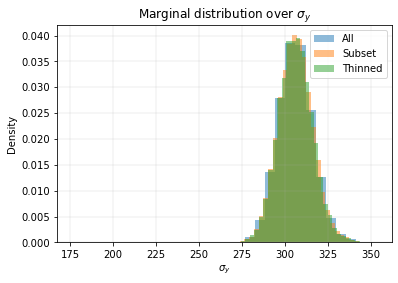

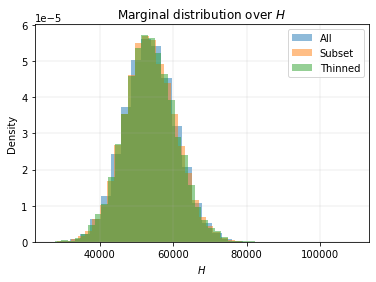

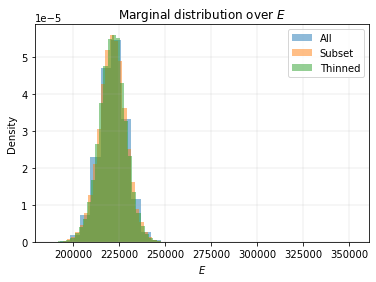

In [15]:
index = np.arange(150000,300000) # Using a subset of the samples
index2 = np.arange(150000,300000)[::10] # With thinning

# YIELD STRESS
plt.figure(1)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(yield_stress_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(yield_stress_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(yield_stress_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $\sigma_y$")
plt.legend()
plt.xlabel(r"$\sigma_y$")
plt.ylabel("Density")

# PLASTIC MODULUS
plt.figure(2)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(H_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(H_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(H_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $H$")
plt.legend()
plt.xlabel(r"$H$")
plt.ylabel("Density")

# ELASTIC MODULUS
plt.figure(3)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(E_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(E_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(E_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $E$")
plt.legend()
plt.xlabel(r"$E$")
plt.ylabel("Density")



### Part 4

$\mathbb{E} \{ \sigma_y \mid \mathbf{\epsilon}, \mathbf{\sigma} \}$, $\mathbb{E} \{ H \mid \mathbf{\epsilon}, \mathbf{\sigma} \}$ and $\mathbb{E} \{ E \mid \mathbf{\epsilon}, \mathbf{\sigma} \}$ were calculated using Monte Carlo integration. This was done with the given samples.  

For example:
\begin{equation}
\mathbb{E} \{{E}\} = \frac{1}{N} \sum_i^N E_i
\end{equation}

Ignoring the burn-in period and making use of thinning could result in slightly increased accuracy.

What is the analytical solution?

Current results:
- 1st value = all samples.
- 2nd value = subset of samples.
- 3rd value = thinned subset.

In [16]:

# ESTIMATES:
print("Expected value estimate of yield stress:   ", np.mean(yield_stress_samples), np.mean(yield_stress_samples[index]),
     np.mean(yield_stress_samples[index2]))

print("Expected value estimate of plastic modulus:", np.mean(H_samples), np.mean(H_samples[index]),
     np.mean(H_samples[index2]))

print("Expected value estimate of Young's modulus:", np.mean(E_samples), np.mean(E_samples[index]),
     np.mean(E_samples[index2]))





Expected value estimate of yield stress:    306.214692641026 306.3307257624954 306.3282521725974
Expected value estimate of plastic modulus: 53728.257905879545 53681.961482316474 53696.84950198777
Expected value estimate of Young's modulus: 221514.7318665411 221451.73031061943 221518.58392888092


### Part 5

The covariance matrix of the posterior samples was calculated. The posterior samples are given. 

The unbiased estimator of the covariance matrix was given by
\begin{equation}
\hat{\mathbf{\Sigma}} = \frac{1}{N-1} \sum_{n=1}^N (\mathbf{x}_n - \hat{\mathbf{\mu}}) (\mathbf{x}_n - \hat{\mathbf{\mu}})^T
\end{equation}

where $\mathbf{x}$ refers to the samples and $\hat{\mathbf{\mu}}$ refers to the mean of the samples.

The covariance matrix was calculated as: ADD.

Therefore, the different variables were negatively correlated with each other. An increase in the yield strength will result in a decreased plastic modulus. DOES IT MAKES SENSE FOR THE DATA AND MODEL?

Figure~\ref{ADD} confirms that the yield strength and plastic modulus are negatively correlated (caption: Illustrating the negative correlation between the plastic modulus and yield strength samples). 

Covariance matrix:
[[ 1.01558548e+02 -5.73853064e+04 -1.87374486e+04]
 [-5.73853064e+04  4.97612283e+07 -2.62052073e+06]
 [-1.87374486e+04 -2.62052073e+06  5.42008327e+07]]


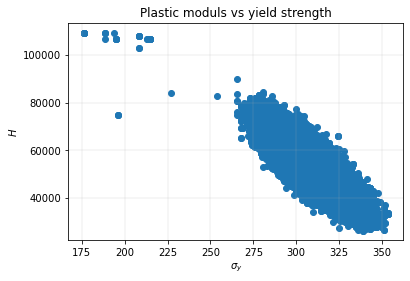

In [84]:
covariance = np.cov(parm_samples, rowvar=False)
print("Covariance matrix:")
print(covariance)


plt.figure(1)
plt.scatter(yield_stress_samples, H_samples)
plt.xlabel('$\sigma_y$')
plt.ylabel('$H$')
plt.title('Plastic moduls vs yield strength')
plt.grid(linewidth=0.2)

### Part 6

Need to plot the mean with bounds (+- 3 std or 5th and 95 percentiles). The mean was taken from the 50\% subset of the samples (ignoring the burn-in period). 

Document the procedure that was used to obtain the posterior predictive distribution.

In [22]:

sigma_y_5 = np.percentile(yield_stress_samples,5)
sigma_y_95 = np.percentile(yield_stress_samples,95)

H_5 = np.percentile(H_samples,5)
H_95 = np.percentile(H_samples,95)

E_5 = np.percentile(E_samples,5)
E_95 = np.percentile(E_samples,95)

print("Yield strength")
print("Mean =", np.mean(yield_stress_samples))
print(sigma_y_5, sigma_y_95)
print("")
print("Plastic modulus")
print("Mean =", np.mean(H_samples))
print(H_5, H_95)
print("")
print("Young's modulus")
print("Mean =", np.mean(E_samples))
print(E_5, E_95)
print("")


Yield strength
Mean = 306.214692641026
290.31511952855385 322.9499197153924

Plastic modulus
Mean = 53728.257905879545
42348.7994019187 65407.40517375437

Young's modulus
Mean = 221514.7318665411
209301.89881809443 233320.11302684594



#### Does not seem correct...

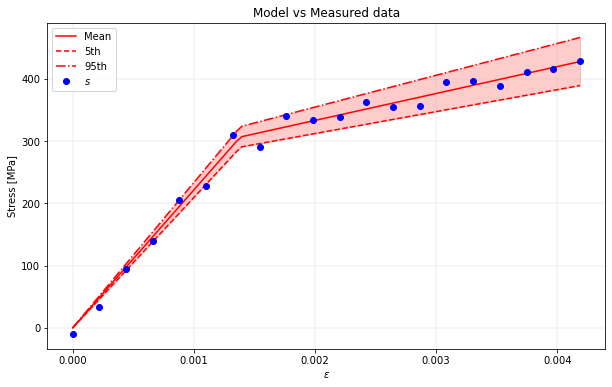

In [82]:
strain_model = np.linspace(0, strain_m[-1], 100)

# Mean
sigma_y = np.mean(yield_stress_samples[index])
H = np.mean(H_samples[index])
E = np.mean(E_samples[index])
model_mean = stress(strain_model, sigma_y, H, E)

# 5th
model_5th = stress(strain_model, sigma_y_5, H_5, E_5)

# 95th
model_95th = stress(strain_model, sigma_y_95, H_95, E_95)

plt.figure(1, (10, 6))
# plt.plot(strain_model, stress_model, 'r', label='$\sigma$')
plt.plot(strain_model, model_mean, 'r', label='Mean')
plt.plot(strain_model, model_5th, 'r--', label='5th')
plt.plot(strain_model, model_95th, 'r-.', label='95th')
plt.fill_between(strain_model, model_5th, model_95th, color="r", alpha = 0.2)  
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$')
plt.ylabel('Stress [MPa]')
plt.title('Model vs Measured data')
plt.grid(linewidth=0.2)
plt.legend()




#### Does not seem correct...


117.90729464889553


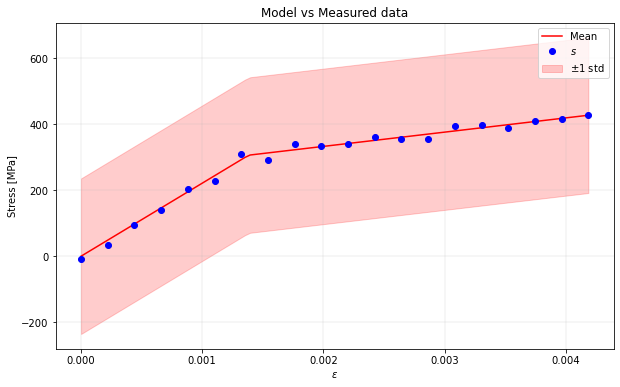

In [86]:

strain_model = np.linspace(0, strain_m[-1], 100)

# Mean
sigma_y = np.mean(yield_stress_samples[index])
H = np.mean(H_samples[index])
E = np.mean(E_samples[index])
model_mean = stress(strain_model, sigma_y, H, E)

std = np.std(model_mean)
print(std)

plt.figure(2, (10, 6))
plt.plot(strain_model, model_mean, 'r', label='Mean')
plt.fill_between(strain_model, model_mean-2*std, model_mean+2*std, color="r", alpha = 0.2, label='$\pm$1 std')  
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$')
plt.ylabel('Stress [MPa]')
plt.title('Model vs Measured data')
plt.grid(linewidth=0.2)
plt.legend()



# std = []
# to_sum = []
# for i in range(20):
#     to_sum.append((stress_m[i]-model_mean[i])**2)
#     pop = i+1
#     std_val = np.sqrt(np.sum(to_sum)/pop)
#     std.append(std_val)
    
# print(std)



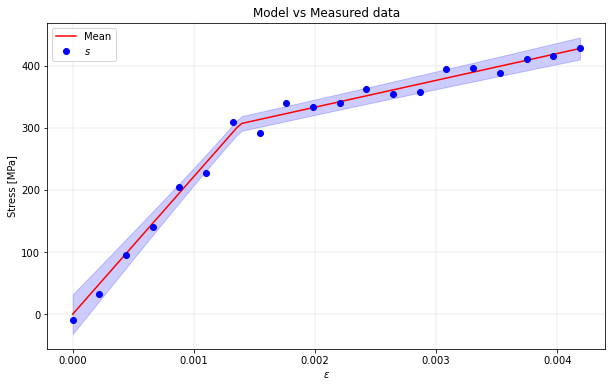

In [83]:
# Playing around...


y_err = model_mean.std() * np.sqrt(1/len(model_mean) +
                          (model_mean - model_mean.mean())**2 / np.sum((model_mean - model_mean.mean())**2))

plt.figure(2, (10, 6))
plt.plot(strain_model, model_mean, 'r', label='Mean')
plt.fill_between(strain_model, (model_mean-y_err), (model_mean+y_err), color='blue', alpha=0.2)
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$')
plt.ylabel('Stress [MPa]')
plt.title('Model vs Measured data')
plt.grid(linewidth=0.2)
plt.legend()





### Part 7

The following probability was calculated:
\begin{equation*}
P (\sigma_y > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})
\end{equation*}

Therefore, given the observed historical data and strain $\epsilon = 0.002$, the probability of $\sigma_y$ being greater than 300 was required.

Since $\sigma_y$ is one of the unknown parameters, it lies in the parameter space. Therefore, the probability would be evaluated using the posterior distribution by marginalising over $H$ and $E$ to obtain a probability distribution over $\sigma_y$ and then using $scistats.norm.cdf$. However, in this case, the empirical marginal distribution has already been determined from the given posterior samples.

The marginal distribution over $\sigma_y$ is given by:
\begin{equation}
p(\sigma_y) = \int_{H} \int_{E} p(\sigma_y, H, E) \; dE \; dH
\end{equation}

In [ ]:

# Still do.


### Part 8

The following probability was calculated:
\begin{equation*}
P (\sigma > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})
\end{equation*}

Therefore, given the observed historical data and strain $\epsilon = 0.002$, the probability of $\sigma$ being greater than 300 was required.

Since $\sigma$ is composed of the three unknown parameters, it lies in the parameter space.

In [ ]:

# Still do.


### Part 9

The following probability was calculated:
\begin{equation*}
P (s > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})
\end{equation*}

Therefore, given the historical data and strain $\epsilon = 0.002$, the probability of a new data point $s$ being greater than 300 was required.

Since $s$ is the measurement variable, it lies in the data space. Therefore, the probability was evaluated using the posterior predictive distribution. For a grid-based approach, the $pdf$ over $s$ would obtained for $\epsilon = 0.002$ and then the $cdf$ thereof would be constructed. However, samples from the posterior distribution were provided. EXPLAIN HOW TO GET RESULT. 

The resulting probability was calculated as ADD.

In [ ]:

# Still do.


### Part 10


Short discussion is expected. Must be able to detail the difference between Part 8 and Part 9 ($\sigma$ vs $s$). What do they quantify?

The probability in Part 7 refers to the unknown parameter $\sigma_y$, which lies in the parameter space. The probability in Part 8 refers to the prediction of the model $\sigma$ comprising the unknown variables $\sigma_y$, $H$ and $E$. Therefore, the prediction of the model also lies in the parameter space (MAKE SURE?). The probability in Part 9 refers to the measurement variable $s$, which lies in the data space. The data space takes into account the variance in the model and the additional noise.   

# Question 5

Note: Rejection sampling and MCMC demos were supplied during the lecture.

This question investigates Markov Chain Monte Carlo. The matropolis algorithm would need to be used (can also try matropolis-hastings algorithm).  

The likelihood function must be in the form provided below. 

For Part 5, mention the following. It must be noted that probability statements can now easily be calculated without even knowing what the model evidence is. Therefore, one does not need to integrate to use the model. Monte Carlo integration was used to calculate the following probability:
\begin{equation}
P (\theta > 2 \mid \mathbf{x}) 
\end{equation}

For Part 6, investigate the effect of making the variance (given as $1^2$) larger. How does this affect the acceptance rate and the calculated probability in Part 5. 

Document the acceptance ratio. 

#### Report content:

The following model was considered:
\begin{equation} \label{eq: q5_gen_model}
x = \theta + \epsilon
\end{equation}

The noise $\epsilon$ was Laplacian distributed with a mean of 0 and a known scaling parameter of 2. Therefore,
\begin{equation} \label{eq: q5_noise}
\epsilon \sim \mathcal{L} (0, 2)
\end{equation}

The generative model is the model that generates the data based on the assumed model. This is given by:
\begin{equation}
p_m (x \mid \theta) = \mathcal{L} (x \mid \theta, 2)
\end{equation}

The conditional distribution is Laplacian because the noise is Laplacian.



### Loading data

In [2]:
dataDict = sio.loadmat("data_question4.mat")
dataDict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x'])

In [3]:
print(dataDict["x"])
print(len(dataDict["x"][0]))

[[-0.82587163  5.30305085  2.30620411  3.01191235  4.52985435  4.18127252
   2.34574774  2.47476611  7.02912906  1.78621867  3.95777362  3.91810862
   2.05206146  1.73298015  2.051348   -0.50053852 -3.1556494   4.29075588
   9.2009711   2.36779369]]
20


2.902894436046423


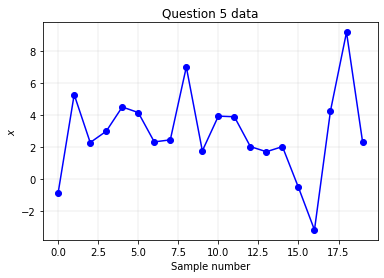

In [4]:
# The data available in the file: 
x_data = dataDict["x"].squeeze()

plt.figure(1)
plt.grid(linewidth=0.2)
plt.plot(x_data, 'bo-')
plt.xlabel("Sample number")
plt.ylabel(r'$x$')
plt.title("Question 5 data")
# plt.savefig('')


print(np.mean(x_data))



### Part 1

The following prior distribution was used:
\begin{equation}
p(\theta) = \mathcal{L} (\theta \mid 0, 4)
\end{equation}

Figure~\ref{ADD} illustrates the prior and log-prior distributions. 

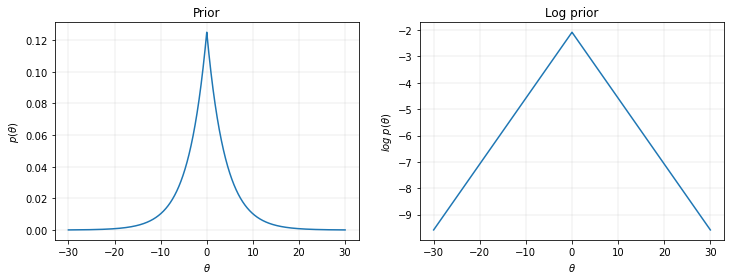

In [5]:

theta_grid = np.linspace(-30, 30, 10000)

def prior(grid):
    theta0 = 0
    prior_scale = 4
    
    prior = scistats.laplace(loc = theta0, scale = prior_scale)
    prior_pdf = prior.pdf(grid)
    return prior_pdf
    
def log_prior(grid):
    theta0 = 0
    prior_scale = 4
    
    prior = scistats.laplace(loc = theta0, scale = prior_scale)
    log_prior = prior.logpdf(grid)
    return log_prior

prior_pdf = prior(theta_grid)
log_prior1 = log_prior(theta_grid)
    
# prior = scistats.laplace(loc = theta0, scale = prior_scale)
# prior_pdf = prior.pdf(theta_grid)
# log_prior = prior.logpdf(theta_grid)

fig1, axs1 = plt.subplots(1, 2, figsize=(12,4))
axs1[0].plot(theta_grid, prior_pdf)
axs1[0].set_xlabel(r'$\theta$')
axs1[0].set_ylabel(r'$p(\theta)$')
axs1[0].set_title('Prior')
axs1[0].grid(linewidth=0.2)
axs1[1].plot(theta_grid, log_prior1) 
axs1[1].set_xlabel(r'$\theta$')
axs1[1].set_ylabel(r'$log \; p(\theta)$')
axs1[1].set_title('Log prior')
axs1[1].grid(linewidth=0.2)
# plt.savefig('')


### Part 2

Only have 1 unknown parameter: $\theta$.

The likelihood function $p(x \mid \theta)$ measures how well the model, with the candidate parameters $\theta$, fit the measured data, i.e. it measures the likelihood that the parameters and the model generated the observed data $x$.

If the data are independently and identically generated, the likelihood function can be written as:
\begin{equation}
\begin{aligned}
p(\mathbf{x} | \theta) &= \prod_{n=1}^N \mathcal{L} (x \mid \theta, 2) \\
&= \prod_{n=1}^N p_m (x \mid \theta)
\end{aligned}
\end{equation}

and the log-likelihood can be written as:
\begin{equation}
log \; p(\mathbf{x} \mid \theta) = \sum_{n=1}^N log \; p_m (x \mid \theta)
\end{equation}

It must be noted that the likelihood function is not a distribution over $\theta$.

Figure~\ref{ADD} illustrates the log-likelihood for the model with the parameter $\theta$ for the given data $\mathbf{x}$. Furthermore, the log-likelihood for the parameter $\theta = 2$ was calculated as ADD.


In [6]:

theta_grid = np.linspace(-30, 30, 10000)

def log_likelihood(theta, x):
    Z = len(x)
    ll = 0
    
    for n in range(Z):
        loc = theta
        scale = 2
        log_of_height = scistats.laplace.logpdf(x[n], loc, scale)
        ll += log_of_height
        
    return ll


Log-likelihood for theta = 2: -47.71769231867652


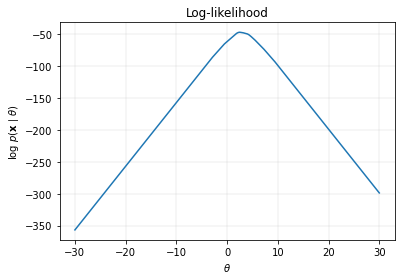

In [7]:

log_like = log_likelihood(theta_grid, x_data)

plt.figure(1)
plt.plot(theta_grid, log_like)
plt.xlabel(r'$\theta$')
plt.ylabel(r'log $p(\mathbf{x} \mid \theta)$')
plt.title('Log-likelihood')
plt.grid(linewidth=0.2)
# plt.savefig('')

log_like_theta2 = log_likelihood(2, x_data)
print("Log-likelihood for theta = 2:", log_like_theta2)


### Part 3

As a result of the dataset remaining constant during the inference procedure, the posterior distribution $p(\theta \mid \mathbf{x})$ and numerator $p(\mathbf{x}, \theta)$ of Bayes' rule are proportional to each other when viewed as a function of $\theta$. 

This numerator $p(\mathbf{x}, \theta)$ is referred to as the unnormalised posterior distribution. It can be decomposed in terms of the likelihood function and the prior:
\begin{equation}
p(\mathbf{x}, \theta) = \tilde{p}(\theta \mid \mathbf{x}) = p(\mathbf{x} \mid \theta) \cdot p(\theta)
\end{equation}

The logarithm of the unnormalised posterior is given by:
\begin{equation}
log \: p(\mathbf{x}, \theta) = log \: p(\mathbf{x} \mid \theta) + log \: p(\theta)
\end{equation}

Figure~\ref{ADD} illustrates the logarithm of the unnormalised posterior for the parameter $\theta$ and the given data $\mathbf{x}$. Furthermore, the logarithm of the unnormalised posterior for the parameter $\theta = 2$ was calculated as ADD.


Logarithm of the unnormalised posterior for theta = 2: -50.297133860356354


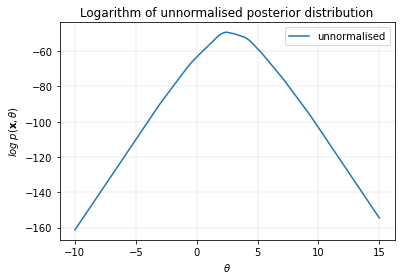

In [27]:
# You are going to use this function in the MCMC calculation:

def log_unnorm_post(theta, x):
    l_prior = log_prior(theta)
    l_like = log_likelihood(theta, x)
    l_un_post = l_prior + l_like
    return l_un_post

log_un_post = log_unnorm_post(theta_grid, x_data)

plt.figure(1)
plt.plot(theta_grid, log_un_post, label='unnormalised')
# plt.plot(theta_grid, log_like, label='log-like')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$log \;p(\mathbf{x}, \theta)$')
plt.title('Logarithm of unnormalised posterior distribution')
plt.grid(linewidth=0.2)
plt.legend()
# plt.savefig('')

log_un_post_theta2 = log_unnorm_post(2, x_data)
print("Logarithm of the unnormalised posterior for theta = 2:", log_un_post_theta2)
    
    
### Without function:    
# # Logarithm of unnormalised posterior distribution:
# log_unnorm_post = log_prior1 + log_like

# plt.figure(2)
# plt.plot(theta_grid, log_unnorm_post, label='unnormalised')
# plt.plot(theta_grid, log_like, label='log-like')
# plt.xlabel(r'$\theta$')
# plt.ylabel(r'$log \;p(\mathbf{x}, \theta)$')
# plt.title('Logarithm of unnormalised posterior distribution')
# plt.grid(linewidth=0.2)
# plt.legend()
# # plt.savefig('')



In [35]:

from scipy import integrate

theta = np.linspace(-30, 30, 1000)
p_tilde =  lambda x: np.exp(log_prior(x) + log_likelihood(x, x_data))
Z = integrate.quad(p_tilde, theta[0], theta[-1])[0]
print('Normalisation constant = Z:',Z)


Normalisation constant = Z: 3.3150600446567214e-22


### Part 4

Document the acceptance ratio.

Need to use the Metropolis algorithm for this (not necessary to use the Metropolis-Hastings algorithm).

Current issue of extreme correlation: watch demo from about 10 minutes, where he explains that the variance is too small. But we are given a variance to use???

#### Report content:

The logarithm of the unnormalised posterior distribution, calculated in Part 3, was used to perform Markov Chain Monte Carlo (MCMC). The following Gaussian proposal distribution was considered reasonable for a first start: 
\begin{equation}
q (\theta_k \mid \theta_{k-1}) = \mathcal{N} (\theta_k \mid \theta_{k-1}, 1^2)
\end{equation}

The proposal distribution is used to sample from the unnormalised posterior distribution. Note that the proposal distribution is Gaussian and, therefore, symmetric. 

The Metropolis sampling algorithm was implemented. For this algorithm, one starts with an initial guess $\theta_0$. For each step $k = 1, 2, ...$:

\begin{itemize}
\item $\theta_{proposal} \tilde q (\theta_k \mid \theta_{k-1})$ (take a sample from the proposal distribution)
\item Calculate $R = \frac{\tilde{p} (\theta_{proposal})}{\tilde{p} (\theta_{k-1})}$
\item Accept the proposal $\theta_{proposal}$ with probability $min (1, R)$. If the proposal is accepted: $\theta_k = \theta_{proposal}$. 
\begin{itemize}

Therefore, one does not need to know the model evidence $Z$ to sample from the posterior. 

A concern regarding the Metropolis algorithm is that one may need to take many samples to get an accurate answer. Alternative algorithms, such as the Metropolis-Hastings algorithm, are intended to resolve this issue and provide the potential for faster convergence.  


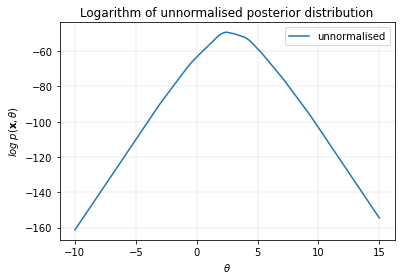

In [9]:
# Want to take samples from this:

def log_unnorm_post(theta, x):
    l_prior = log_prior(theta)
    l_like = log_likelihood(theta, x)
    l_un_post = l_prior + l_like
    return l_un_post

theta_grid = np.linspace(-10, 15, 10000)

log_un_post = log_unnorm_post(theta_grid, x_data)

plt.figure(1)
plt.plot(theta_grid, log_un_post, label='unnormalised')
# plt.plot(theta_grid, log_like, label='log-like')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$log \;p(\mathbf{x}, \theta)$')
plt.title('Logarithm of unnormalised posterior distribution')
plt.grid(linewidth=0.2)
plt.legend()





Firstly, different values for $\theta_{prev}$ were considered individually to ensure that the correct behaviour was observed and to investigate it's influence. This $\theta_{prev}$ value was used as the mean of the proposal distribution. An example of the case where $\theta_{prev} = ADD$ is shown in Figure~\ref{ADD}.  

It must be noted that the posterior distribution was obtained after integrating the unnormalised posterior to get the model evidence $Z$. This was for visualisation purposes and for a reason discussed later. Figure~\ref{ADD} illustrates the same sample on the logarithm of the unnormalised posterior distribution.   

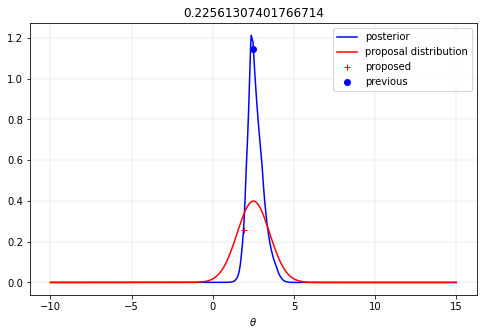

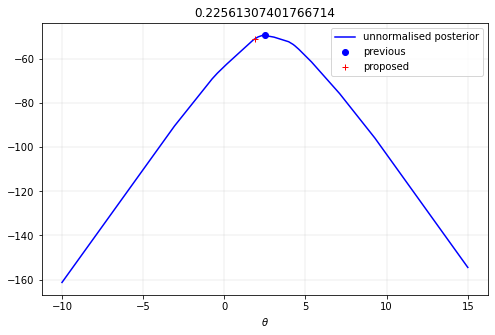

In [37]:

theta_prev = 2.5 # 2.5

q_prop = scistats.norm(loc=theta_prev, scale=1) # proposal distribution. Used to sample from distribution above.

theta_prop = q_prop.rvs() # sample from proposal

expon = np.exp(log_unnorm_post(theta_grid, x_data))
exp_max = np.max(expon)

# We are going to determine whether theta_proposed is better than theta_previous... 
# R = np.min([1, log_unnorm_post(theta_prop, x_data)/log_unnorm_post(theta_prev, x_data)])
# New:
R = np.min([1, ((np.exp(log_unnorm_post(theta_prop, x_data))/Z)/(np.exp(log_unnorm_post(theta_prev, x_data))/Z))]) # Metropolis algorithm

# fig1, axs1 = plt.subplots(1, 2, figsize=(13,4))
# axs1[0].plot(theta_grid, q_prop.pdf(theta_grid),'r', label='proposal distribution')
# axs1[0].plot(theta_prop, np.exp(log_unnorm_post(theta_prop, x_data))/exp_max,"r+", label='proposal sample')
# axs1[0].plot(theta_grid, expon/exp_max,'b', label="unnormalised posterior")
# axs1[0].set_xlabel(r'$\theta$')
# axs1[0].grid(linewidth=0.2)
# axs1[0].legend()
# axs1[1].plot(theta_grid, expon/exp_max,'b', label="unnormalised posterior")
# axs1[1].plot(theta_prop, np.exp(log_unnorm_post(theta_prop, x_data))/exp_max,"r+", label='proposed')
# axs1[1].plot(theta_prev, np.exp(log_unnorm_post(theta_prev, x_data))/exp_max,"bo", label='previous')
# axs1[1].set_xlabel(r'$\theta$')
# axs1[1].set_title(R)
# axs1[1].grid(linewidth=0.2)
# axs1[1].legend()

plt.figure(1, (8, 5))
plt.grid(linewidth=0.2)
plt.plot(theta_grid, expon/Z,'b', label="posterior")
plt.plot(theta_grid, q_prop.pdf(theta_grid),'r', label='proposal distribution')
plt.plot(theta_prop, np.exp(log_unnorm_post(theta_prop, x_data))/Z,"r+", label='proposed')
plt.plot(theta_prev, np.exp(log_unnorm_post(theta_prev, x_data))/Z,"bo", label='previous')
plt.xlabel(r'$\theta$')
plt.title(R)
plt.legend()

# plt.figure(2)
# plt.grid(linewidth=0.2)
# plt.plot(theta_grid, log_unnorm_post(theta_grid, x_data),'b')
# plt.plot(theta_grid, q_prop.pdf(theta_grid),'r', label='proposal distribution')
# plt.plot(theta_prop, log_unnorm_post(theta_prop, x_data),"r+", label='proposal sample')
# plt.xlabel(r'$\theta$')
# plt.legend()

plt.figure(3, (8, 5))
plt.grid(linewidth=0.2)
plt.plot(theta_grid, log_unnorm_post(theta_grid, x_data),'b', label="unnormalised posterior")
plt.plot(theta_prev, log_unnorm_post(theta_prev, x_data),"bo", label='previous')
plt.plot(theta_prop, log_unnorm_post(theta_prop, x_data),"r+", label='proposed')
plt.xlabel(r'$\theta$')
plt.title(R)
plt.legend()


In the plots above, the title refers to the calculated $R$ value. If $R = 1$ then we accept the sample (the value of 'theta').

$R$ value tells us how much we are improving or getting worse. Therefore, value of 1 implies that there is an improvement that is 100% certain. Therefore, the $R$ value refers to a probability. For example, if $R = 0.44$, we will accept the sample with a probability of 44\%.

Thereafter, the process was automated. 10 000 samples were taken. A sample was drawn from a uniform distribution and it was accepted if $R$ was greater than the sample. In the case of a sample being accepted, $\theta_{prev}$ is assigned the value of $\theta_{prop}$ (sampled $\theta$ from the proposal distribution).   

This process was first attempted using the logarithm of the unnormalised posterior distribution. However, the calculated values for $R$ were non-sensical. This resulted from the different representations of the proposal distribution and the logarithm of the unnormalised posterior distribution. The samples were shown to be highly correlated and not considered to be independently sampled. Additionally, the obtained histogram was unsensible. This indicated that the variance was too small for this problem. The proposed Gaussian had a very tight variance compared to the logarithm of the unnormalised posterior distribution, therefore, a proposed solution will be very close to the previous solution so we might accept it but we are not progressing with the solution.

However, equivalent scales had to be used for comparative purposes and the posterior distribution was considered. The obtained samples are illustrated in Figure~\ref{ADD} and the histrogram of the samples is illustrated in Figure~\ref{ADD}. For an initial $\theta_{prev} = ADD$ and the scaling parameter of 1, the acceptance ratio was ADD\%. The histogram of the samples is shown to represent the unnormalised posterior distribution fairly accurately.  

The efficiency of the algorithm is evaluated by counting the number of samples that were accepted. Results have shown that the Metropolis algorithm is optimal if it has an efficiency of 44% for one-dimensional problems. The acceptance ratio calculated for this problem was around 45-49\% and was considered sufficient. 

Additionally, the correlation between the samples and itself was calculated. The shifts ('noise') around zero refer to estimation errors. Figure~\ref{ADD} shows that the $\theta$ samples are mostly correlated with itself and there is not much structure in the correlation. Therefore, it was found that the samples were uncorrelated. This is shown by the sample plot that indicates the samples were likely independently sampled and they were shown to rapidly converge to the domain of the actual solution for different $\theta_{prev}$.

However, the choice of $\theta_{prev}$ had a significant effect on the relation between the histogram of the samples and the unnormalised posterior distribution. Therefore, the choice influenced the convergence and this was expected for the Metropolis algorithm. Improved performance would be achieved if alternative algorithms were used.   


In [52]:

theta_prev = 2.5 # -5, 5, 2.5
theta_acc  = []
acc = 0

num_samples = 10000

for k in range(num_samples):
    print(k)

    q_prop = scistats.norm(loc=theta_prev, scale=1) # Change scale here...

    theta_prop = q_prop.rvs()

#     R = np.min([1, log_unnorm_post(theta_prop, x_data)/log_unnorm_post(theta_prev, x_data)]) # Metropolis
    # New:
    R = np.min([1, ((np.exp(log_unnorm_post(theta_prop, x_data))/Z)/(np.exp(log_unnorm_post(theta_prev, x_data))/Z))]) # Metropolis algorithm


    u = np.random.rand() # draw sample from uniform distribution.
    if R > u: # accept
        acc += 1
        theta_prev = float(theta_prop)

    theta_acc.append(theta_prev)

theta_acc = np.array(theta_acc)

print("")
print("Acceptance:")
print(acc) # count of how many samples were accepted.
print("Ratio: {} %".format((acc/num_samples)*100))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713


5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359


6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005


8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654


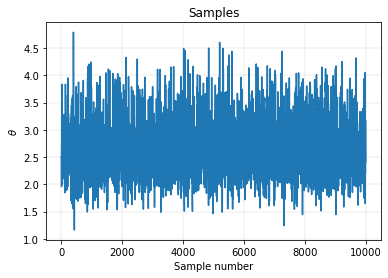

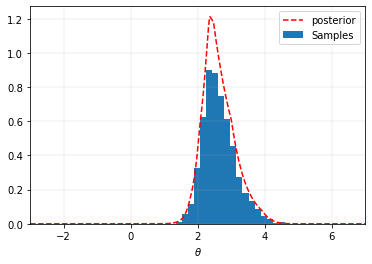

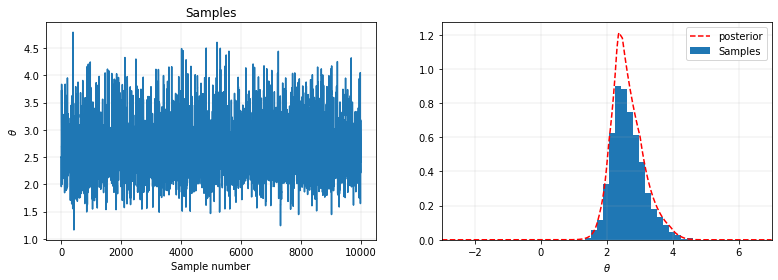

In [53]:

plt.figure(1)
plt.grid(linewidth=0.2)
plt.plot(theta_acc)
plt.xlabel("Sample number")
plt.ylabel(r"$\theta$")
plt.title("Samples")

plt.figure(2)
plt.grid(linewidth=0.2)
plt.plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled... 
plt.hist(theta_acc, density=True, bins=20, label="Samples")
plt.xlabel(r"$\theta$")
plt.ylabel("")
plt.legend()
plt.xlim(-3, 7)


fig1, axs1 = plt.subplots(1, 2, figsize=(13,4))
axs1[0].plot(theta_acc)
axs1[0].set_ylabel(r'$\theta$')
axs1[0].set_xlabel('Sample number')
axs1[0].set_title("Samples")
axs1[0].grid(linewidth=0.2)
axs1[1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[1].hist(theta_acc, density=True, bins=20, label="Samples")
axs1[1].set_xlabel(r'$\theta$')
axs1[1].set_xlim(-3, 7)
axs1[1].grid(linewidth=0.2)
axs1[1].legend()


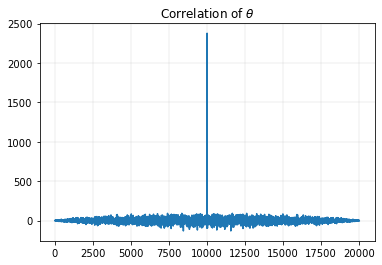

In [54]:

import scipy.signal as scisig

corr_theta = scisig.correlate(theta_acc-np.mean(theta_acc), theta_acc-np.mean(theta_acc))

plt.figure(1)
plt.plot(corr_theta)
plt.title(r"Correlation of $\theta$")
plt.grid(linewidth=0.2)



It was decided to investigate using a subset of the samples (ignoring the potential burn-in/warm-up period), as well as thinning. Thinning can be used to reduce correlation. 

Case 1:
- Subset of samples from 5000 to 10000 (50\%). A conservative approach is to discard half of the samples [Schmidt notes].
- Thinning of this subset, taking every 10th sample.

Implementing Case 1 showed to have a negligible affect on the distribution. A small improvement is made in the distribution's relation to the calculated posterior. This supports that the samples were not highly correlated.   

Taking larger steps in the case of thinning the sample subset of Case 1 generally provided inaccurate distributions with larger variations and less relation to the calculated posterior. This is illustrated in Figure~\ref{ADD}.

Furthermore, decreasing the size of the sample subset only resulted in distribution deviations when the subset was approximately smaller than 20 (20\% of total). This is illustrated in Figure~\ref{ADD}.  




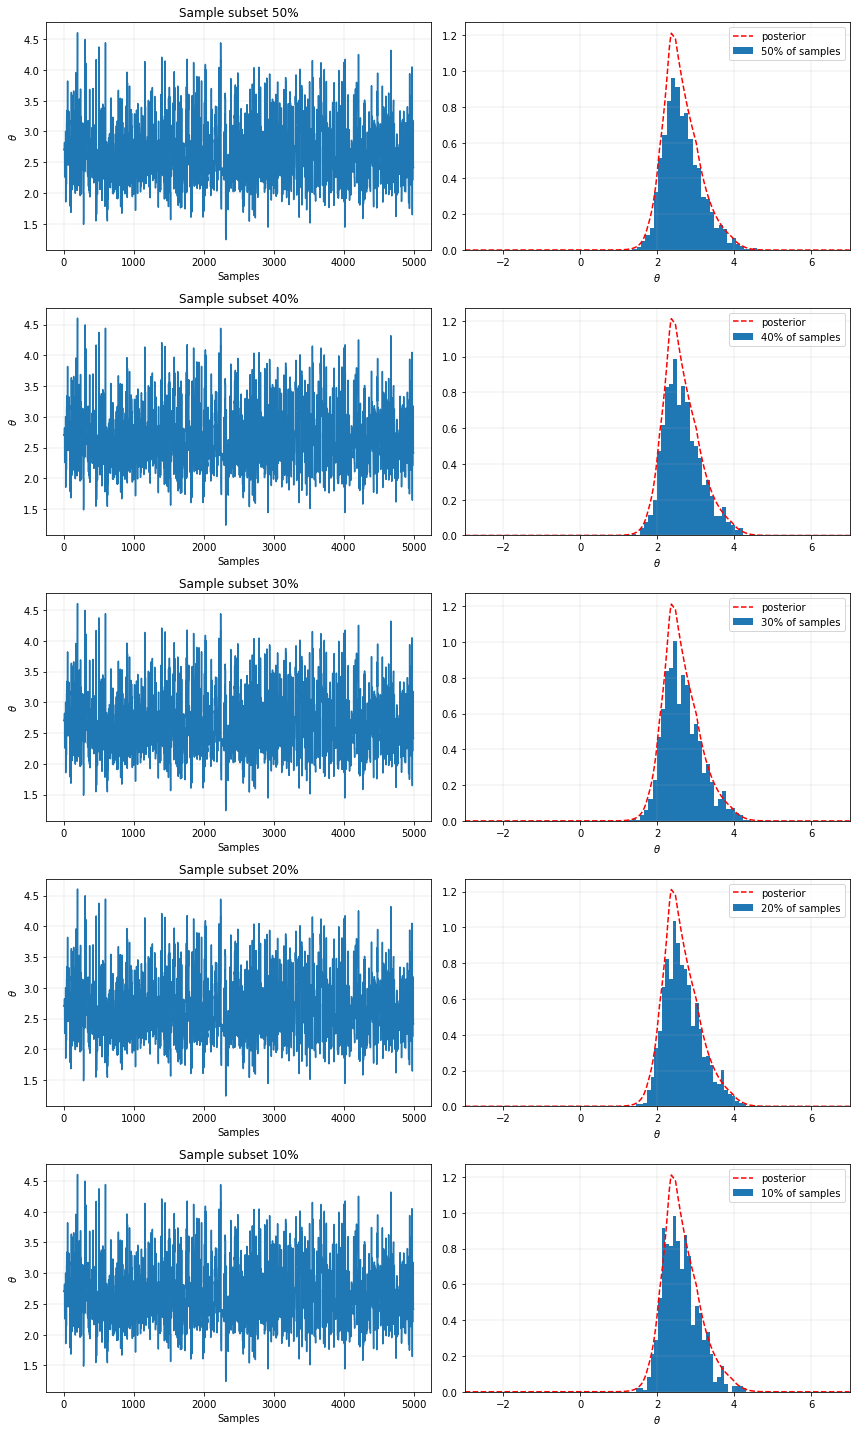

In [55]:

index1 = np.arange(5000,10000) # 50% subset
index2 = np.arange(6000,10000) # 40% subset
index3 = np.arange(7000,10000) # 30% subset
index4 = np.arange(8000,10000) # 20% subset
index5 = np.arange(9000,10000) # 10% subset

fig1, axs1 = plt.subplots(5, 2, figsize=(12,20))
axs1[0][0].plot(theta_acc[index1])
axs1[0][0].set_xlabel('Samples')
axs1[0][0].set_ylabel(r"$\theta$")
axs1[0][0].set_title('Sample subset 50%')
axs1[0][0].grid(linewidth=0.2)
axs1[0][1].hist(theta_acc[index1], density=True, bins=30, label="50% of samples")
axs1[0][1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") 
axs1[0][1].set_xlabel(r"$\theta$")
# axs1[0][1].set_ylabel("")
# axs1[0][1].set_title(r"")
axs1[0][1].set_xlim(-3, 7)
axs1[0][1].legend()
axs1[0][1].grid(linewidth=0.2)

axs1[1][0].plot(theta_acc[index1])
axs1[1][0].set_xlabel('Samples')
axs1[1][0].set_ylabel(r"$\theta$")
axs1[1][0].set_title('Sample subset 40%')
axs1[1][0].grid(linewidth=0.2)
axs1[1][1].hist(theta_acc[index2], density=True, bins=30, label="40% of samples")
axs1[1][1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[1][1].set_xlabel(r"$\theta$")
# axs1[1][1].set_ylabel("")
# axs1[1][1].set_title(r"")
axs1[1][1].set_xlim(-3, 7)
axs1[1][1].legend()
axs1[1][1].grid(linewidth=0.2)

axs1[2][0].plot(theta_acc[index1])
axs1[2][0].set_xlabel('Samples')
axs1[2][0].set_ylabel(r"$\theta$")
axs1[2][0].set_title('Sample subset 30%')
axs1[2][0].grid(linewidth=0.2)
axs1[2][1].hist(theta_acc[index3], density=True, bins=30, label="30% of samples")
axs1[2][1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[2][1].set_xlabel(r"$\theta$")
# axs1[2][1].set_ylabel("")
# axs1[2][1].set_title(r"")
axs1[2][1].set_xlim(-3, 7)
axs1[2][1].legend()
axs1[2][1].grid(linewidth=0.2)

axs1[3][0].plot(theta_acc[index1])
axs1[3][0].set_xlabel('Samples')
axs1[3][0].set_ylabel(r"$\theta$")
axs1[3][0].set_title('Sample subset 20%')
axs1[3][0].grid(linewidth=0.2)
axs1[3][1].hist(theta_acc[index4], density=True, bins=30, label="20% of samples")
axs1[3][1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[3][1].set_xlabel(r"$\theta$")
# axs1[3][1].set_ylabel("")
# axs1[3][1].set_title(r"")
axs1[3][1].set_xlim(-3, 7)
axs1[3][1].legend()
axs1[3][1].grid(linewidth=0.2)

axs1[4][0].plot(theta_acc[index1])
axs1[4][0].set_xlabel('Samples')
axs1[4][0].set_ylabel(r"$\theta$")
axs1[4][0].set_title('Sample subset 10%')
axs1[4][0].grid(linewidth=0.2)
axs1[4][1].hist(theta_acc[index5], density=True, bins=30, label="10% of samples")
axs1[4][1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[4][1].set_xlabel(r"$\theta$")
# axs1[4][1].set_ylabel("")
# axs1[4][1].set_title(r"")
axs1[4][1].set_xlim(-3, 7)
axs1[4][1].legend()
axs1[4][1].grid(linewidth=0.2)

fig1.tight_layout()
# plt.savefig('')


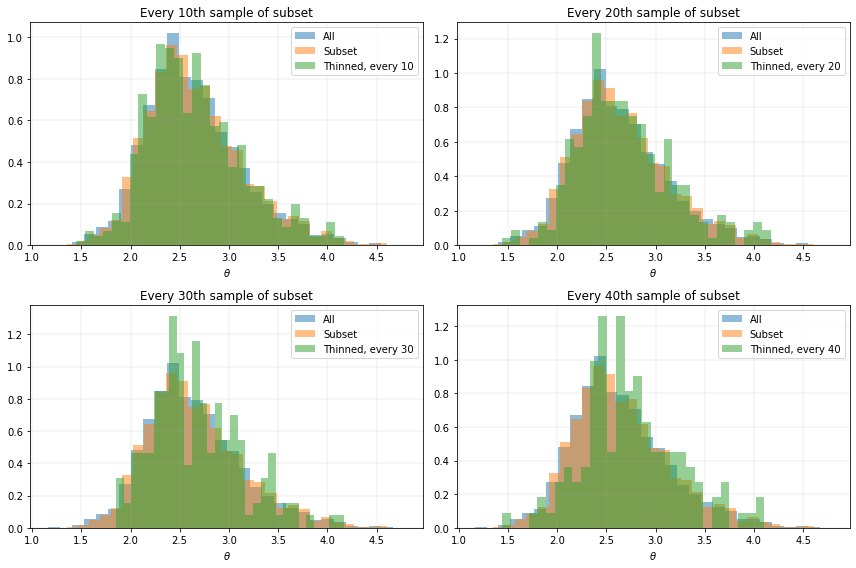

In [56]:
index = np.arange(5000,10000)

index1 = np.arange(5000,10000)[::10] # 50% subset, every 10
index2 = np.arange(5000,10000)[::20] # 50% subset, every 20
index3 = np.arange(5000,10000)[::30] # 50% subset, every 30
index4 = np.arange(5000,10000)[::40] # 50% subset, every 40

fig1, axs1 = plt.subplots(2, 2, figsize=(12,8))
axs1[0][0].hist(theta_acc,density=True,bins=30, alpha=0.5, label='All')
axs1[0][0].hist(theta_acc[index],density=True,bins=30, alpha=0.5, label='Subset')
axs1[0][0].hist(theta_acc[index1],density=True,bins=30, alpha=0.5, label='Thinned, every 10')
axs1[0][0].set_xlabel(r"$\theta$")
# axs1[0][0].set_ylabel(r"$\theta$")
axs1[0][0].set_title('Every 10th sample of subset')
axs1[0][0].legend()
axs1[0][0].grid(linewidth=0.2)

axs1[0][1].hist(theta_acc,density=True,bins=30, alpha=0.5, label='All')
axs1[0][1].hist(theta_acc[index],density=True,bins=30, alpha=0.5, label='Subset')
axs1[0][1].hist(theta_acc[index2],density=True,bins=30, alpha=0.5, label='Thinned, every 20')
axs1[0][1].set_xlabel(r"$\theta$")
# axs1[0][1].set_ylabel(r"$\theta$")
axs1[0][1].set_title('Every 20th sample of subset')
axs1[0][1].legend()
axs1[0][1].grid(linewidth=0.2)

axs1[1][0].hist(theta_acc,density=True,bins=30, alpha=0.5, label='All')
axs1[1][0].hist(theta_acc[index],density=True,bins=30, alpha=0.5, label='Subset')
axs1[1][0].hist(theta_acc[index3],density=True,bins=30, alpha=0.5, label='Thinned, every 30')
axs1[1][0].set_xlabel(r"$\theta$")
# axs1[1][0].set_ylabel(r"$\theta$")
axs1[1][0].set_title('Every 30th sample of subset')
axs1[1][0].legend()
axs1[1][0].grid(linewidth=0.2)

axs1[1][1].hist(theta_acc,density=True,bins=30, alpha=0.5, label='All')
axs1[1][1].hist(theta_acc[index],density=True,bins=30, alpha=0.5, label='Subset')
axs1[1][1].hist(theta_acc[index4],density=True,bins=30, alpha=0.5, label='Thinned, every 40')
axs1[1][1].set_xlabel(r"$\theta$")
# axs1[1][1].set_ylabel(r"$\theta$")
axs1[1][1].set_title('Every 40th sample of subset')
axs1[1][1].legend()
axs1[1][1].grid(linewidth=0.2)

fig1.tight_layout()
# plt.savefig('')



### Part 5

It must be noted that probability statements can now easily be calculated without even knowing what the model evidence is. Therefore, one does not need to integrate to use the model. Monte Carlo integration was used to calculate the following probability:
\begin{equation}
P (\theta > 2 \mid \mathbf{x}) 
\end{equation}

Therefore, given the data, the probability of $\theta$ being greater than 2 was required.

Since $\theta$ is one of the unknown parameters, it lies in the parameter space.

The probability was calculated as ADD. 
 


In [47]:
from IPython.display import display, Latex


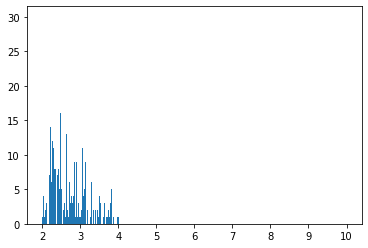

<IPython.core.display.Latex object>

In [58]:

theta = np.linspace(2, 10, len(theta_acc))

pdf1,_,_ = plt.hist(theta_acc, theta, density=False) 
plt.show()

proba = np.sum(pdf1)/len(pdf1)

display(Latex(r'Using MC $P(\theta>2 \mid \mathbf{x})$ = '+str(proba)))


### Part 6

Should also mention something to do with correlation. Smaller variance will increase correlation and take longer to converge. Prove with figures?

Add more discussion based on results in table. 

#### Report content:

5 scenarios were tested, as detailed in Table~\ref{}. A constant $\theta_{prev} = 2.5$ was used.

ADD TABLE (Columns: Scenario, standard dev., Acc. ratio, Part 5 prob.).

The proposal distribution variance is important as it determines the range from which samples are taken. It may be too large, therefore, proposing unsensible samples. This highlights the importance of the parameter tuning process.

Additionally, smaller variance will increase correlation, generally resulting in more samples being accepted and result in a poorly representative distribution. A smaller variance will also take longer to converge. The high correlation resulted in unsensible histogram representations of the posterior. The proposed Gaussian had a very tight variance compared to the posterior distribution, therefore, a proposed solution will be very close to the previous solution so we might accept it but we are not progressing with the solution.



#### Case 1:

In [59]:

theta_prev = 2.5 # -5, 5, 2.5
theta_acc  = []
acc = 0

num_samples = 10000

for k in range(num_samples):
    print(k)

    q_prop = scistats.norm(loc=theta_prev, scale=0.01) # Change scale here...

    theta_prop = q_prop.rvs()

#     R = np.min([1, log_unnorm_post(theta_prop, x_data)/log_unnorm_post(theta_prev, x_data)]) # Metropolis
    # New:
    R = np.min([1, ((np.exp(log_unnorm_post(theta_prop, x_data))/Z)/(np.exp(log_unnorm_post(theta_prev, x_data))/Z))]) # Metropolis algorithm


    u = np.random.rand() # draw sample from uniform distribution.
    if R > u: # accept
        acc += 1
        theta_prev = float(theta_prop)

    theta_acc.append(theta_prev)

theta_acc = np.array(theta_acc)

print("")
print("Acceptance:")
print(acc) # count of how many samples were accepted.
print("Ratio: {} %".format((acc/num_samples)*100))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711


5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353


6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992


8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632


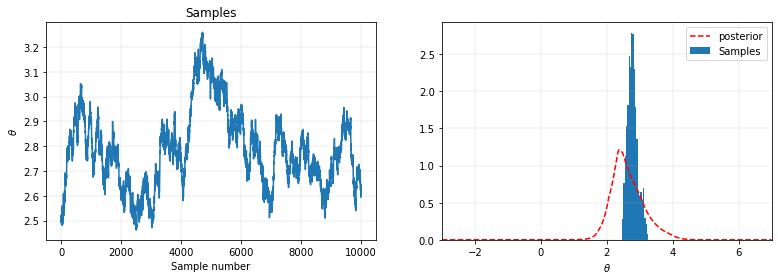

In [60]:
fig1, axs1 = plt.subplots(1, 2, figsize=(13,4))
axs1[0].plot(theta_acc)
axs1[0].set_ylabel(r'$\theta$')
axs1[0].set_xlabel('Sample number')
axs1[0].set_title("Samples")
axs1[0].grid(linewidth=0.2)
axs1[1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[1].hist(theta_acc, density=True, bins=20, label="Samples")
axs1[1].set_xlabel(r'$\theta$')
axs1[1].set_xlim(-3, 7)
axs1[1].grid(linewidth=0.2)
axs1[1].legend()

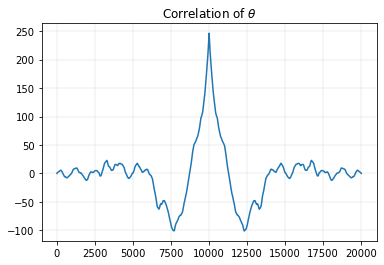

In [61]:
corr_theta = scisig.correlate(theta_acc-np.mean(theta_acc), theta_acc-np.mean(theta_acc))
plt.figure(1)
plt.plot(corr_theta)
plt.title(r"Correlation of $\theta$")
plt.grid(linewidth=0.2)

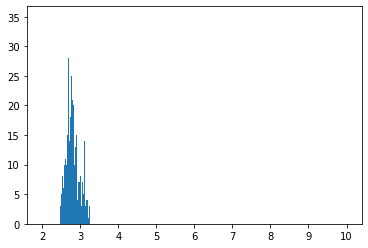

<IPython.core.display.Latex object>

In [62]:
theta = np.linspace(2, 10, len(theta_acc))

pdf1,_,_ = plt.hist(theta_acc, theta, density=False) 
plt.show()

proba = np.sum(pdf1)/len(pdf1)

display(Latex(r'Using MC $P(\theta>2 \mid \mathbf{x})$ = '+str(proba)))

#### Case 2:

In [63]:
theta_prev = 2.5 # -5, 5, 2.5
theta_acc  = []
acc = 0

num_samples = 10000

for k in range(num_samples):
    print(k)

    q_prop = scistats.norm(loc=theta_prev, scale=0.1) # Change scale here...

    theta_prop = q_prop.rvs()

#     R = np.min([1, log_unnorm_post(theta_prop, x_data)/log_unnorm_post(theta_prev, x_data)]) # Metropolis
    # New:
    R = np.min([1, ((np.exp(log_unnorm_post(theta_prop, x_data))/Z)/(np.exp(log_unnorm_post(theta_prev, x_data))/Z))]) # Metropolis algorithm


    u = np.random.rand() # draw sample from uniform distribution.
    if R > u: # accept
        acc += 1
        theta_prev = float(theta_prop)

    theta_acc.append(theta_prev)

theta_acc = np.array(theta_acc)

print("")
print("Acceptance:")
print(acc) # count of how many samples were accepted.
print("Ratio: {} %".format((acc/num_samples)*100))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072


3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722


5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367


6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010


8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650


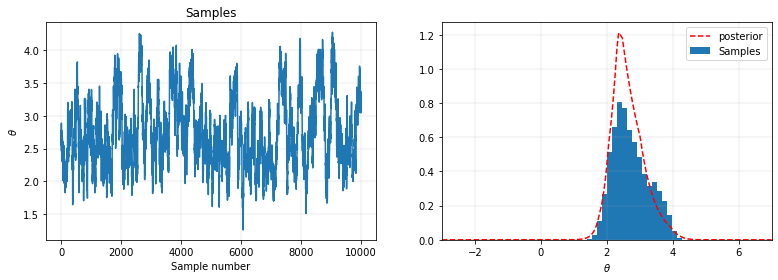

In [64]:
fig1, axs1 = plt.subplots(1, 2, figsize=(13,4))
axs1[0].plot(theta_acc)
axs1[0].set_ylabel(r'$\theta$')
axs1[0].set_xlabel('Sample number')
axs1[0].set_title("Samples")
axs1[0].grid(linewidth=0.2)
axs1[1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[1].hist(theta_acc, density=True, bins=20, label="Samples")
axs1[1].set_xlabel(r'$\theta$')
axs1[1].set_xlim(-3, 7)
axs1[1].grid(linewidth=0.2)
axs1[1].legend()

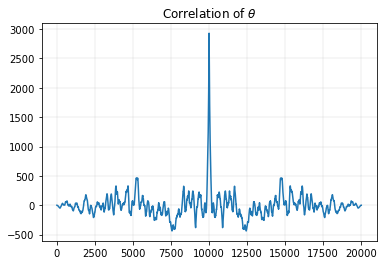

In [65]:
corr_theta = scisig.correlate(theta_acc-np.mean(theta_acc), theta_acc-np.mean(theta_acc))
plt.figure(1)
plt.plot(corr_theta)
plt.title(r"Correlation of $\theta$")
plt.grid(linewidth=0.2)

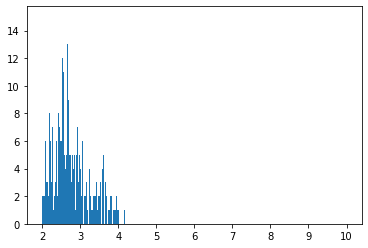

<IPython.core.display.Latex object>

In [66]:
theta = np.linspace(2, 10, len(theta_acc))

pdf1,_,_ = plt.hist(theta_acc, theta, density=False) 
plt.show()

proba = np.sum(pdf1)/len(pdf1)

display(Latex(r'Using MC $P(\theta>2 \mid \mathbf{x})$ = '+str(proba)))

#### Case 3:

Original scale value of 1.

#### Case 4:

In [67]:
theta_prev = 2.5 # -5, 5, 2.5
theta_acc  = []
acc = 0

num_samples = 10000

for k in range(num_samples):
    print(k)

    q_prop = scistats.norm(loc=theta_prev, scale=10) # Change scale here...

    theta_prop = q_prop.rvs()

#     R = np.min([1, log_unnorm_post(theta_prop, x_data)/log_unnorm_post(theta_prev, x_data)]) # Metropolis
    # New:
    R = np.min([1, ((np.exp(log_unnorm_post(theta_prop, x_data))/Z)/(np.exp(log_unnorm_post(theta_prev, x_data))/Z))]) # Metropolis algorithm


    u = np.random.rand() # draw sample from uniform distribution.
    if R > u: # accept
        acc += 1
        theta_prev = float(theta_prop)

    theta_acc.append(theta_prev)

theta_acc = np.array(theta_acc)

print("")
print("Acceptance:")
print(acc) # count of how many samples were accepted.
print("Ratio: {} %".format((acc/num_samples)*100))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711


5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359


6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008


8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649


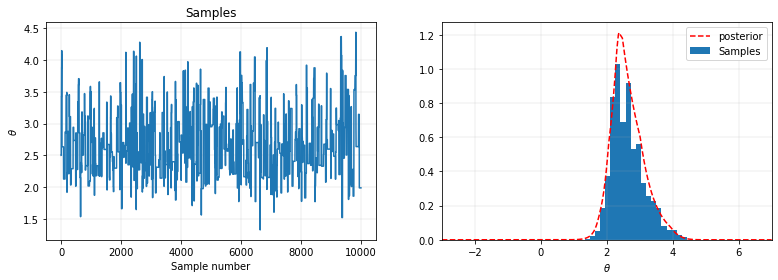

In [68]:
fig1, axs1 = plt.subplots(1, 2, figsize=(13,4))
axs1[0].plot(theta_acc)
axs1[0].set_ylabel(r'$\theta$')
axs1[0].set_xlabel('Sample number')
axs1[0].set_title("Samples")
axs1[0].grid(linewidth=0.2)
axs1[1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[1].hist(theta_acc, density=True, bins=20, label="Samples")
axs1[1].set_xlabel(r'$\theta$')
axs1[1].set_xlim(-3, 7)
axs1[1].grid(linewidth=0.2)
axs1[1].legend()

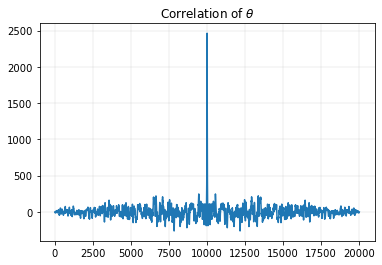

In [69]:
corr_theta = scisig.correlate(theta_acc-np.mean(theta_acc), theta_acc-np.mean(theta_acc))
plt.figure(1)
plt.plot(corr_theta)
plt.title(r"Correlation of $\theta$")
plt.grid(linewidth=0.2)

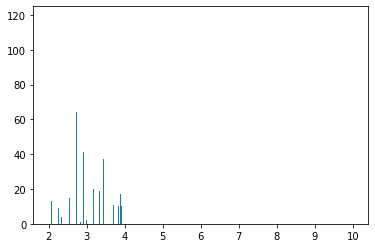

<IPython.core.display.Latex object>

In [70]:
theta = np.linspace(2, 10, len(theta_acc))

pdf1,_,_ = plt.hist(theta_acc, theta, density=False) 
plt.show()

proba = np.sum(pdf1)/len(pdf1)

display(Latex(r'Using MC $P(\theta>2 \mid \mathbf{x})$ = '+str(proba)))

#### Case 5:

In [71]:
theta_prev = 2.5 # -5, 5, 2.5
theta_acc  = []
acc = 0

num_samples = 10000

for k in range(num_samples):
    print(k)

    q_prop = scistats.norm(loc=theta_prev, scale=100) # Change scale here...

    theta_prop = q_prop.rvs()

#     R = np.min([1, log_unnorm_post(theta_prop, x_data)/log_unnorm_post(theta_prev, x_data)]) # Metropolis
    # New:
    R = np.min([1, ((np.exp(log_unnorm_post(theta_prop, x_data))/Z)/(np.exp(log_unnorm_post(theta_prev, x_data))/Z))]) # Metropolis algorithm


    u = np.random.rand() # draw sample from uniform distribution.
    if R > u: # accept
        acc += 1
        theta_prev = float(theta_prop)

    theta_acc.append(theta_prev)

theta_acc = np.array(theta_acc)

print("")
print("Acceptance:")
print(acc) # count of how many samples were accepted.
print("Ratio: {} %".format((acc/num_samples)*100))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708


5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352


6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994


8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637


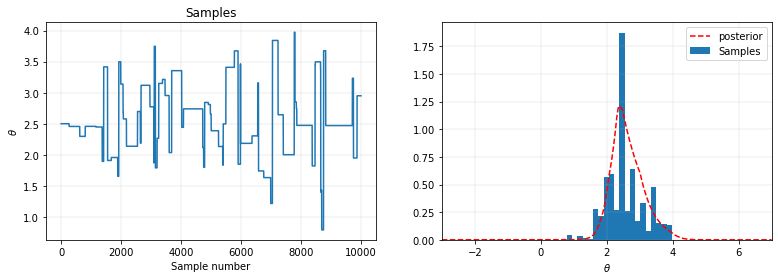

In [72]:
fig1, axs1 = plt.subplots(1, 2, figsize=(13,4))
axs1[0].plot(theta_acc)
axs1[0].set_ylabel(r'$\theta$')
axs1[0].set_xlabel('Sample number')
axs1[0].set_title("Samples")
axs1[0].grid(linewidth=0.2)
axs1[1].plot(theta_grid, np.exp(log_unnorm_post(theta_grid, x_data))/Z, 'r--', label="posterior") # scaled...
axs1[1].hist(theta_acc, density=True, bins=20, label="Samples")
axs1[1].set_xlabel(r'$\theta$')
axs1[1].set_xlim(-3, 7)
axs1[1].grid(linewidth=0.2)
axs1[1].legend()

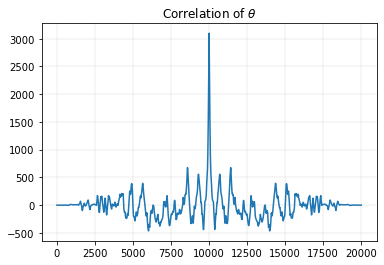

In [73]:
corr_theta = scisig.correlate(theta_acc-np.mean(theta_acc), theta_acc-np.mean(theta_acc))
plt.figure(1)
plt.plot(corr_theta)
plt.title(r"Correlation of $\theta$")
plt.grid(linewidth=0.2)

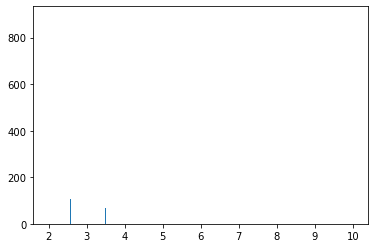

<IPython.core.display.Latex object>

In [74]:
theta = np.linspace(2, 10, len(theta_acc))

pdf1,_,_ = plt.hist(theta_acc, theta, density=False) 
plt.show()

proba = np.sum(pdf1)/len(pdf1)

display(Latex(r'Using MC $P(\theta>2 \mid \mathbf{x})$ = '+str(proba)))

# Question 6

